In [1]:
import pandas as pd
import numpy as np
from function import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('data_sim.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
n = 10000

eps = 0 # np.random.normal(0, 0.1, n)

a = 2
b = 2

b0=0.5
b1 = 0.5

sim = 10000

p = 0.7

In [4]:
df = df[:n]

In [5]:
#df   = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])

#df.to_csv('data_sim.csv')  

In [6]:
omega = pd.DataFrame(np.random.binomial(size=n, n=1, p= 0.7),columns=['X2'])

In [7]:
def sobol_ipw(df,n1,request,sim,a,b,eps):
    sobol_list = []
    df1 = df.copy()
    for x in range(sim):
        df_pf   = dataset(n1,df).picked(request,a,b)
        df1['Y']    =dataset(n1,df1).ishigami(eps)(a,b)/p
        df_pf['Y'] = dataset(n1,df_pf).ishigami(eps)(a,b)/p
        sobol_list.append((np.cov(df1.Y,df_pf.Y)/np.var(df1.Y))[0][1])
    return sobol_list

In [8]:
def higher_sobols(df,n1,sim,a,b,eps):
    singleton = []
    for x in [['X3'],['X1'],['X2'],[]]:
        singleton.append(sobol_ipw(df,n1,x,sim,a,b,eps))
    return pd.DataFrame(dict(zip(['X1_X2','X2_X3','X1_X3'],singleton)))

In [9]:
def higher_sobol(df,Xi,n,p,sample):
    omega = pd.DataFrame(np.random.binomial(size=n, n=1, p= p),columns=[Xi])
    omega[df.drop([Xi],axis=1).columns]=  np.ones((n,2),dtype=int)
    cc = df.where(omega==1,np.nan).dropna()
    print(len(cc))
    higher_sobol_cc = higher_sobols(cc,len(cc),sim,a,b,eps)
    #fig, ax = plt.subplots()
    #ax.boxplot(single_sobol_cc)
    #ax.set_xticklabels(single_sobol_cc.columns)
    higher_sobol_cc['sample'] = sample
    return higher_sobol_cc

10000
7044
6892
6732
6791
6975
7267
7066
7096
X1 is missing


<ipython-input-10-cc0e5ebfccd9>:38: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'


10000
7020
6898
6761
6737
7065
7187
6989
7084
X2 is missing


<ipython-input-10-cc0e5ebfccd9>:38: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'


10000
7026
6867
6743
6761
6961
7298
7009
7113
X3 is missing


<ipython-input-10-cc0e5ebfccd9>:38: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'


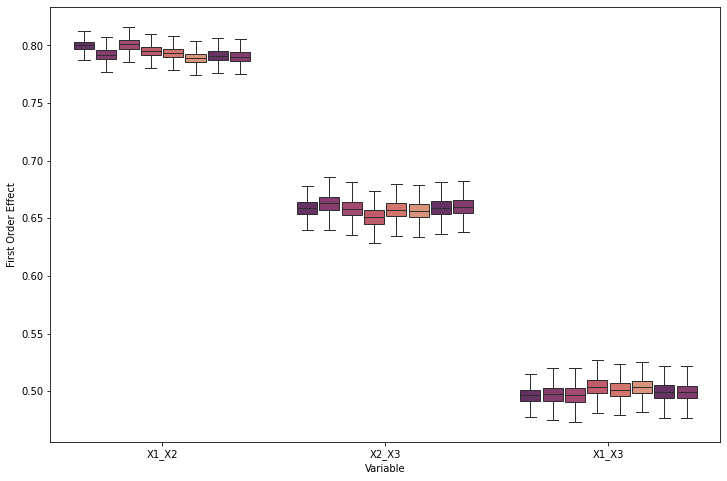

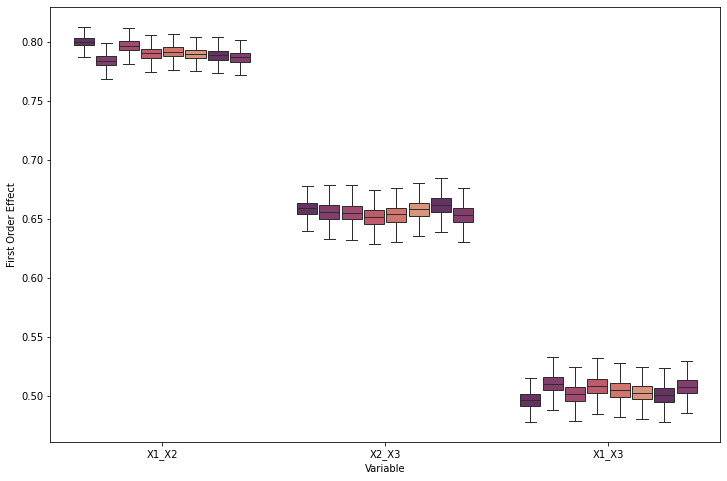

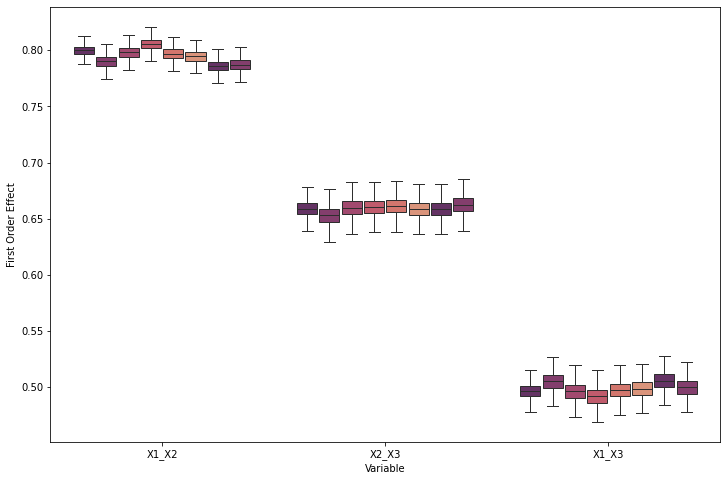

In [10]:
p = 0.7
b0=0.5
b1 = 0.5


for x in ['X1','X2','X3']:
    single_sobol = higher_sobol(df,x,n,1,'complete')
    single_sobol_cc = higher_sobol(df,x,n,p,'cc')

    
    y = dataset(n,df.copy()).ishigami(eps)(a,b)

    single_sobol_cc_y = higher_sobol(df,x,n,pi(0.5*y,b0,b1),'mar_y')

    single_sobol_cc_xj = higher_sobol(df,x,n,pi(df[df.drop([x],axis=1).columns[0]],b0,b1),'mar_xk')

    single_sobol_cc_xk = higher_sobol(df,x,n,pi(df[df.drop([x],axis=1).columns[1]],b0,b1),'mar_xj')

    single_sobol_cc_xx = higher_sobol(df,x,n,pi(0.7*df[df.drop([x],axis=1).columns].sum(axis=1),b0,b1),'mar_x')
    
    single_sobol_cc_xxy = higher_sobol(df,x,n,pi(0.4*y + 0.5 *df[df.drop([x],axis=1).columns].sum(axis=1),b0,b1),'mar_xxy')
    
    single_sobol_cc_yxj = higher_sobol(df,x,n,pi(0.4*y + 0.5 * df[df.drop([x],axis=1).columns[0]],b0,b1),'mar_xky')
    
    single_sobol_cc_yxk = higher_sobol(df,x,n,pi(0.5*y + 0.5 * df[df.drop([x],axis=1).columns[1]],b0,b1),'mar_xjy')
    
    print(x+ ' is missing')
    cdf = pd.concat([single_sobol, #single_sobol_cc,
                    single_sobol_cc_y,single_sobol_cc_xj,single_sobol_cc_xk,single_sobol_cc_xx,single_sobol_cc_xxy,
                    single_sobol_cc_yxj,single_sobol_cc_yxk],axis=0)  
    
    dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1_X2','X2_X3','X1_X3'],var_name='Variable')
    dd = dd.rename(columns={'value':'First Order Effect'})
    dd.to_csv(f'simulation/mar_run/mar_mix/{x}_ipw.csv')
 
    fig, ax = plt.subplots(1, 1,figsize=(12, 8))
    
    ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'
    ax.legend_.remove()
    #ax.set(ylim=(0, 0.7))
    fig = ax.get_figure()
    adjust_box_widths(fig, 0.9)
    fig.savefig('simulation/mar/mar_mix/MAR_'+str(x)+'10k_ipw.pdf',transparent=True,bbox_inches='tight')


In [11]:
dfs_mar = [pd.read_csv(f'simulation/mar_run/mar_mix/{x}_ipw.csv') for x in ['X1','X2','X3']]


In [12]:
dfs_mar[0]

,Unnamed: 0,sample,Variable,First Order Effect
0,0,complete,X1_X2,0.804377
1,1,complete,X1_X2,0.803708
2,2,complete,X1_X2,0.793846
3,3,complete,X1_X2,0.800032
4,4,complete,X1_X2,0.807440
...,...,...,...,...
239995,239995,mar_xjy,X1_X3,0.502534
239996,239996,mar_xjy,X1_X3,0.507532
239997,239997,mar_xjy,X1_X3,0.496444
239998,239998,mar_xjy,X1_X3,0.498255


<ipython-input-15-3e4c67fd4cec>:3: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'
<ipython-input-15-3e4c67fd4cec>:3: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'
<ipython-input-15-3e4c67fd4cec>:3: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'


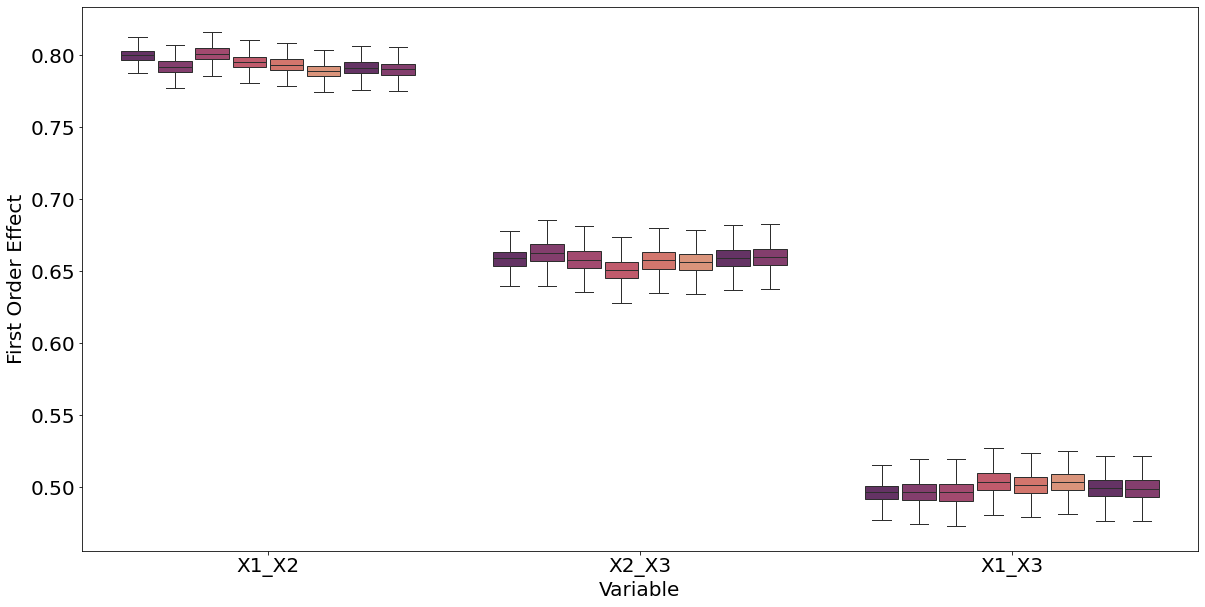

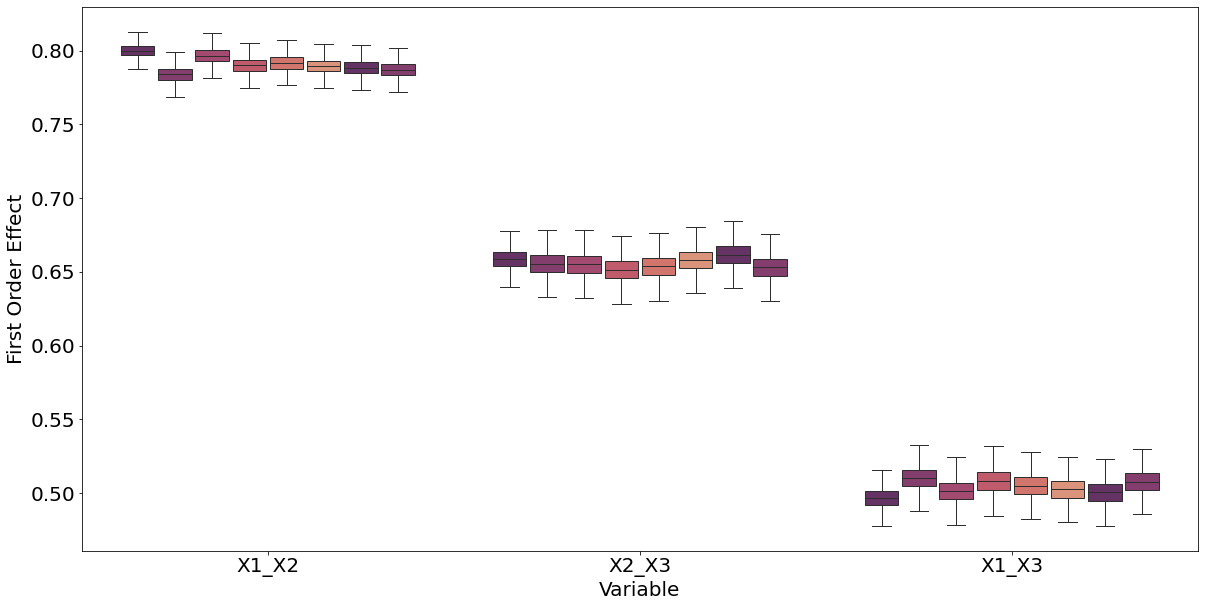

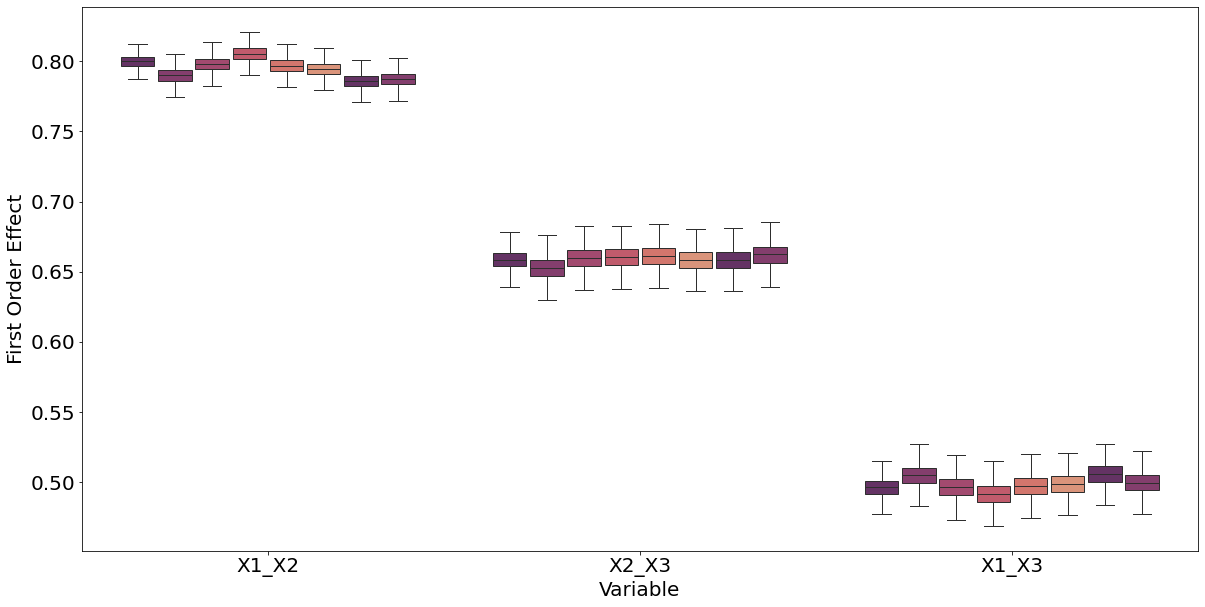

In [15]:
for dd,x in zip(dfs_mar,['X1','X2','X3']): #,'X3'
    fig, ax = plt.subplots(1, 1,figsize=(20, 10))
    ax = sns.boxplot(x='Variable',y='First Order Effect',data=dd,hue='sample',palette=sns.color_palette('flare_r'),showfliers = False) #"Blues" "cubehelix" flare_r'
    ax.legend_.remove()
    #ax.set(ylim=(0.1, 0.55))
    fig = ax.get_figure()
    adjust_box_widths(fig, 0.9)
    plt.xticks(fontsize = 20) 
    plt.yticks(fontsize = 20) 
    ax.set_xlabel('Variable', fontsize = 20) 
    ax.set_ylabel('First Order Effect', fontsize = 20) 
    fig.savefig('simulation/mar/mar_mix/MAR_'+str(x)+'10k_ipw_mix.pdf',transparent=True,bbox_inches='tight')

    

